## Schneeflockensimulation

Da es draußen eher weniger weiße Weihnacht vor der Tür ist, wollen wir uns heute unsere Schneeflocken kurzerhand selber basteln. Der Algorighmus basiert auf einem [Paper](https://patarnott.com/pdf/SnowCrystalGrowth.pdf) von C.A. Reiter. Dieser ist ein verhältnismäßig simpler Algorithmus, der trotzdem in der Lage ist, komplexe 2D-Schneeflocken zu erstellen.

Ein schönes Video zu der Physik von Schneeflocken und deren verschiedenen Formen (in 3D) findet sich auch [hier](https://www.youtube.com/watch?v=ao2Jfm35XeE)

Wir erstellen eine Klasse _snowflake_, damit wir die einzelnen Schritte nachher einfach ausführen können.

### Imports & Initialisierung

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


class snowflake():
    """
    Creates a grid modelling a snowflake. Initialized with model parameters
    alpha: the diffusion coefficient
    beta: the background level
    gamma: the added constant to the receptive cells

    """

    def __init__(self, alpha, beta, gamma, grid_size=250, maxiter=500, plot_period=10):
        # Snowflake parameters
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        # Size of water grid
        self.grid_size = int(grid_size)

        # maximum number of iterations
        # + 1 so that the last image is also plottet in the animation
        self.maxiter = maxiter + 1
        

        # Initialize the water grid with background water level
        self.grid = beta * np.ones((self.grid_size, self.grid_size))

        # Seed the snowflake at the center of the field
        self.grid[self.grid_size // 2, self.grid_size // 2] = 1

        # dx, dy displacements from a cell to get to its hexagonal neighbors
        # as represented in the grid
        self.dcell = [[-1, -1], [0, -1], [-1, 0], [1, 0], [0, 1], [1, 1]]
        
        # For animations
        self.plot_period = plot_period

        # Initialize an empty array for saving a picture every "plot_period"
        self.images = np.empty((self.maxiter // self.plot_period + 1,
                                2 * self.grid_size, 2 * self.grid_size))

### Geometrische Transformation des pseudo-hexagonalen Grids auf ein hexagonales Bild

In [2]:
class snowflake(snowflake):
    def transform_grid_to_image(self):
        # Geometric transformation from square grid to hexagonal for image displaying
        # Cos (-45 deg), sin(-45 deg), y-scaling factor
        sn, cs, sc = np.sin(-np.pi / 4), np.cos(-np.pi / 4), np.sqrt(3)
        # Image height and width
        height, width = 2 * self.grid_size, 2 * self.grid_size
        # center position in image
        imcx, imcy = width // 2, height // 2
        # Image array (< 1 is water, >= 1 is ice)
        im = np.zeros((height, width))

        # Indices of square mesh
        kx, ky = np.indices([width, height])

        # Map square mesh to hexagonal mesh
        tx0 = kx - imcx
        ty0 = (ky - imcy) * sc
        tx = tx0 * cs - ty0 * sn + imcx
        ty = tx0 * sn + ty0 * cs + imcy

        # Boolean mask to stay within bounds
        bounds_mask = (0 <= tx) & (tx <= width) & (0 <= ty) & (ty <= height)

        # Cast to integers and copy values
        ci = ((self.grid_size // 2 - 1) * ty[bounds_mask] / self.grid_size).astype(int)
        cj = ((self.grid_size // 2 - 1) * tx[bounds_mask] / self.grid_size).astype(int)

        im[bounds_mask] = np.where(self.grid[ci, cj] >= 1, self.grid[ci, cj], 0)

        return im

### Schrittweises Wachsen auf dem quadratischen Grid

Hier müsst ihr noch die Diffusion implementieren!

In [3]:
class snowflake(snowflake):
    def grow(self, save_intermediate=False):
        # Grow the snowflake on the 2D square grid
        for it in range(self.maxiter):
            # Determining which cells are "receptive"
            # Every cell that is already iced (>=1)
            receptive = (self.grid >= 1)
            # And every cell that has an iced neighbor
            for x, y in self.dcell:
                receptive |= (np.roll(np.roll(self.grid, x, 0), y, 1) >= 1)

            # Add constant water flow to the receptive cells
            receptive_grid = receptive * (self.grid + self.gamma)

            # Determining the unreceptive cells simply by every cell that's not (~) receptive
            unreceptive = (~receptive)

            # The values of the unreceptive grid (before diffusion)
            unreceptive_grid = unreceptive * self.grid

            # calculating the hexagonal diffusion
            # 1. The center weighted with -6
            diffusion_grid = -6 * unreceptive_grid
            # 2. The nearest neighbors in the hexagonal lattice with 1
            for x, y in self.dcell:
                diffusion_grid += np.roll(unreceptive_grid, shift=[x, y], axis=[0, 1])
            # Adding the diffusion to the unreceptive grid times the diffusion constant alpha
            # We also divide by 12 just to have the same alpha coefficient as in the paper
            unreceptive_grid += self.alpha / 12 * diffusion_grid
            self.grid = receptive_grid + unreceptive_grid
            
            
            if save_intermediate and it % self.plot_period == 0:
                self.images[it // self.plot_period] = self.transform_grid_to_image()

### Plot

In [8]:
class snowflake(snowflake):
    def show_last_image(self):
        self.grow()
        im = self.transform_grid_to_image()
        plt.figure(figsize=(10, 10))
        plt.imshow(-im, cmap="Greys")
        plt.show()

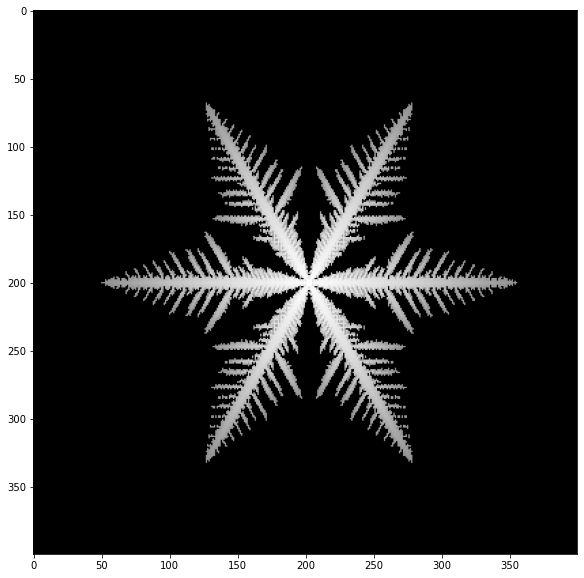

In [9]:
sf1 = snowflake(2, 0.4, 0.001, grid_size=200, maxiter=1000)
sf1.show_last_image()

### Das ganze jetzt als Animation

In [6]:
class snowflake(snowflake):
    def animate_grow(self):
        self.grow(save_intermediate=True)        
    
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Display the initial image
        img = ax.imshow(-self.images[0], animated=True, cmap="Greys")

        # Define the update function for the animation
        def update(frame):
            # Update the image data
            img.set_array(-self.images[frame])
            return img,

        
        # Create the animation
        animation = FuncAnimation(fig, update, frames=self.images.shape[0], interval=50)
        # 'Once' as default instead of looping the animation
        animation.repeat = False

        # Display the animation in the Jupyter Notebook
        from IPython.display import HTML
        html_output = HTML(animation.to_jshtml())
        display(html_output)
        plt.close()

In [7]:
sf1 = snowflake(2, 0.40, 0.001, grid_size=200, maxiter=1000)
sf1.animate_grow()

### Und jetzt ? 
Seien Sie kreativ! Spielen Sie mit den Parametern, aber auch mit dem Code.
Sie können beispielsweise auch
1. Einen neuen "seed" wählen. Momentan setzen wir den Pixel in der Mitte auf 1 und wachsen unsere Schneeflocke drum herum. Sie können aber auch ein Anfangsmuster vorgeben.
2. Sie können die Parameter $\alpha$, $\beta$ und $\gamma$ auch *während* der Simulation ändern. Also im Code in die For-Schleife eingreifen. Z.B. kann man so erst ein Hexagon wachsen lassen und dann viele Zweige hinzufügen.
3. Sie können anstatt eines konstanten Hintergrundes auch hier ein Muster vorgeben, oder ein zufällig gewähltes.
4. Ändern Sie auch gerne die Farben der [Colormap](https://matplotlib.org/stable/users/explain/colors/colormap-manipulation.html), oder erstellen Sie gar ihre eigene.

Laden Sie gerne ein Bild auf unsere [Galerie](https://johannestrommer.com/cloud/index.php/s/WzKiFfQXfyb7dWD) hoch!